<h3> Import Necessary Python Libraries </h3>

In [1]:
import os
import sys
from tqdm import tqdm
import random
import numpy as np

In [2]:
import ML
import config
from Standard import SpectralAverage
from datetime import datetime

<h1> Running a CNN Experiment </h1>
<h4> First, set your arguments below: </h4>

In [3]:
args = {
    # data configuration
    "data_type": 'spectra',
    "studies_folder": '/wavi/EEGstudies',
    "study_name": 'lyons_pain',
    "balance": 'CU_control',
    "eval_study": 'CU_pain',
    "task": 'P300',
    "length": 250,
    "channels": '1111111111111111111',
    "artifact": ''.join(map(str, config.custom_art_map)),
    "erp_degree": 1,
    "filter_band": 'hidelta',
    # neural net
    "epochs": 25,
    "normalize": None,
    "plot_ROC": False,
    "plot_hist": True,
    "tt_split": 0, # no validation set now
    "learning_rate": 0.01,
    "lr_decay": True,
    "checkpoint_dir": ""
}

<h4> Build Data Path </h4>

In [4]:
# build the WAVi data configuration path
# from args given above
patient_path = args['studies_folder']\
    + '/'\
    + args['study_name']\
    + '/'\
    + args['data_type']\
    + '/'\
    + args['task']\
    + '_'\
    + str(args['length'])\
    + '_'\
    + args['channels']\
    + '_'\
    + str(args['artifact'])

if args['erp_degree'] is not None:
    patient_path += ("_" + str(args['erp_degree']))

<h4> Instantiate Classifer Object and Load Data </h4>

In [5]:
# Instantiate a 'Classifier' Object
myclf = ML.Classifier(args['data_type'])

<h4> Load in patient-positive (HIGH condition data) </h4>

In [6]:
# Load in patient-positive (HIGH condition data)

# for filename in the folder of spectra/contigs 
# that we defined above
for fname in os.listdir(patient_path):
    
    # if the subject owner of the file 
    # hasn't yet been processed
    if fname[:config.participantNumLen] not in config.exclude_subs:
        
        # and the file's filter matches 
        # that which we defined
        # (probably hidelta = >2Hz filter)
        if "_"+args['filter_band'] in fname:
            
            # then load that data into object
            # @ myclf.data = []
            myclf.LoadData(
                patient_path
                +"/"
                +fname)

<h4> Load in control-negative (LOW condition data) </h4>

In [7]:
# Load in control-negative (LOW condition data)
balance_path = patient_path.replace(args['study_name'], args['balance'])

#all fnames in path
fnames = os.listdir(balance_path)
subjects = list(set(
    [fname[:config.participantNumLen] for fname in fnames if
        (fname[:config.participantNumLen]
            not in config.exclude_subs)]))

random.shuffle(subjects)

for h, sub in enumerate(subjects):
    sub_fnames = [fname for fname in fnames if subjects[h] == fname[:config.participantNumLen]]

    for fname in sub_fnames:
        if "_"+args['filter_band'] in fname:
            myclf.LoadData(
                balance_path
                + "/"
                + fname)

<h4> Equalize Data Class Sizes </h4>

In [8]:
# pop off data from the class with less data until class sizes are equal
groups = []
for dataObj in myclf.data:
    if dataObj.group not in groups:
        groups.append(dataObj.group)
            
group_sizes = []
for group in groups:
    group_size = 0
    for dataObj in myclf.data:
        if dataObj.group == group:
            group_size+=1
    group_sizes.append(group_size)
    
random.shuffle(myclf.data)

if len(groups) != 2:
    raise ValueError
else:
    larger_group = group_sizes.index(np.max(group_sizes))
    smaller_group = group_sizes.index(np.min(group_sizes))
    
for i, group in enumerate(groups):
    print("Type:", config.group_names[group], "\tAmount:", group_sizes[i])

Type: Pain 	Amount: 125
Type: Control 	Amount: 544


In [9]:
i = 0
while group_sizes[larger_group] > group_sizes[smaller_group]:
    if myclf.data[i].group == groups[larger_group]:
        myclf.data.pop(i)
        group_sizes[larger_group]-=1
    else:
        i += 1
        
for i, group in enumerate(groups):
    print("Type:", config.group_names[group], "\tAmount:", group_sizes[i])

Type: Pain 	Amount: 125
Type: Control 	Amount: 125


<h4> Load the Data into TF-Ready Format </h4>
<p> This includes several lists: </p>

- myclf.train_dataset (numpy.array of data)

- myclf.test_dataset (numpy.array of data)

- myclf.train_labels (numpy.array of binary label values)

- myclf.test_labels (numpy.array of binary label values)

In [10]:
myclf.Prepare(tt_split=0)

Number of negative outcomes: 125
Number of positive outcomes: 125
Total number of subjects: 16
% Positive in all subjects: 0.4375
% Negative in all subjects: 0.5625
Number of samples in train: 250
Number of samples in test: 250
% Positive samples in train: 0.5
% Positive samples in test: 0.0


<h4> Show Spectral Averages of Training Data, by Group </h4>

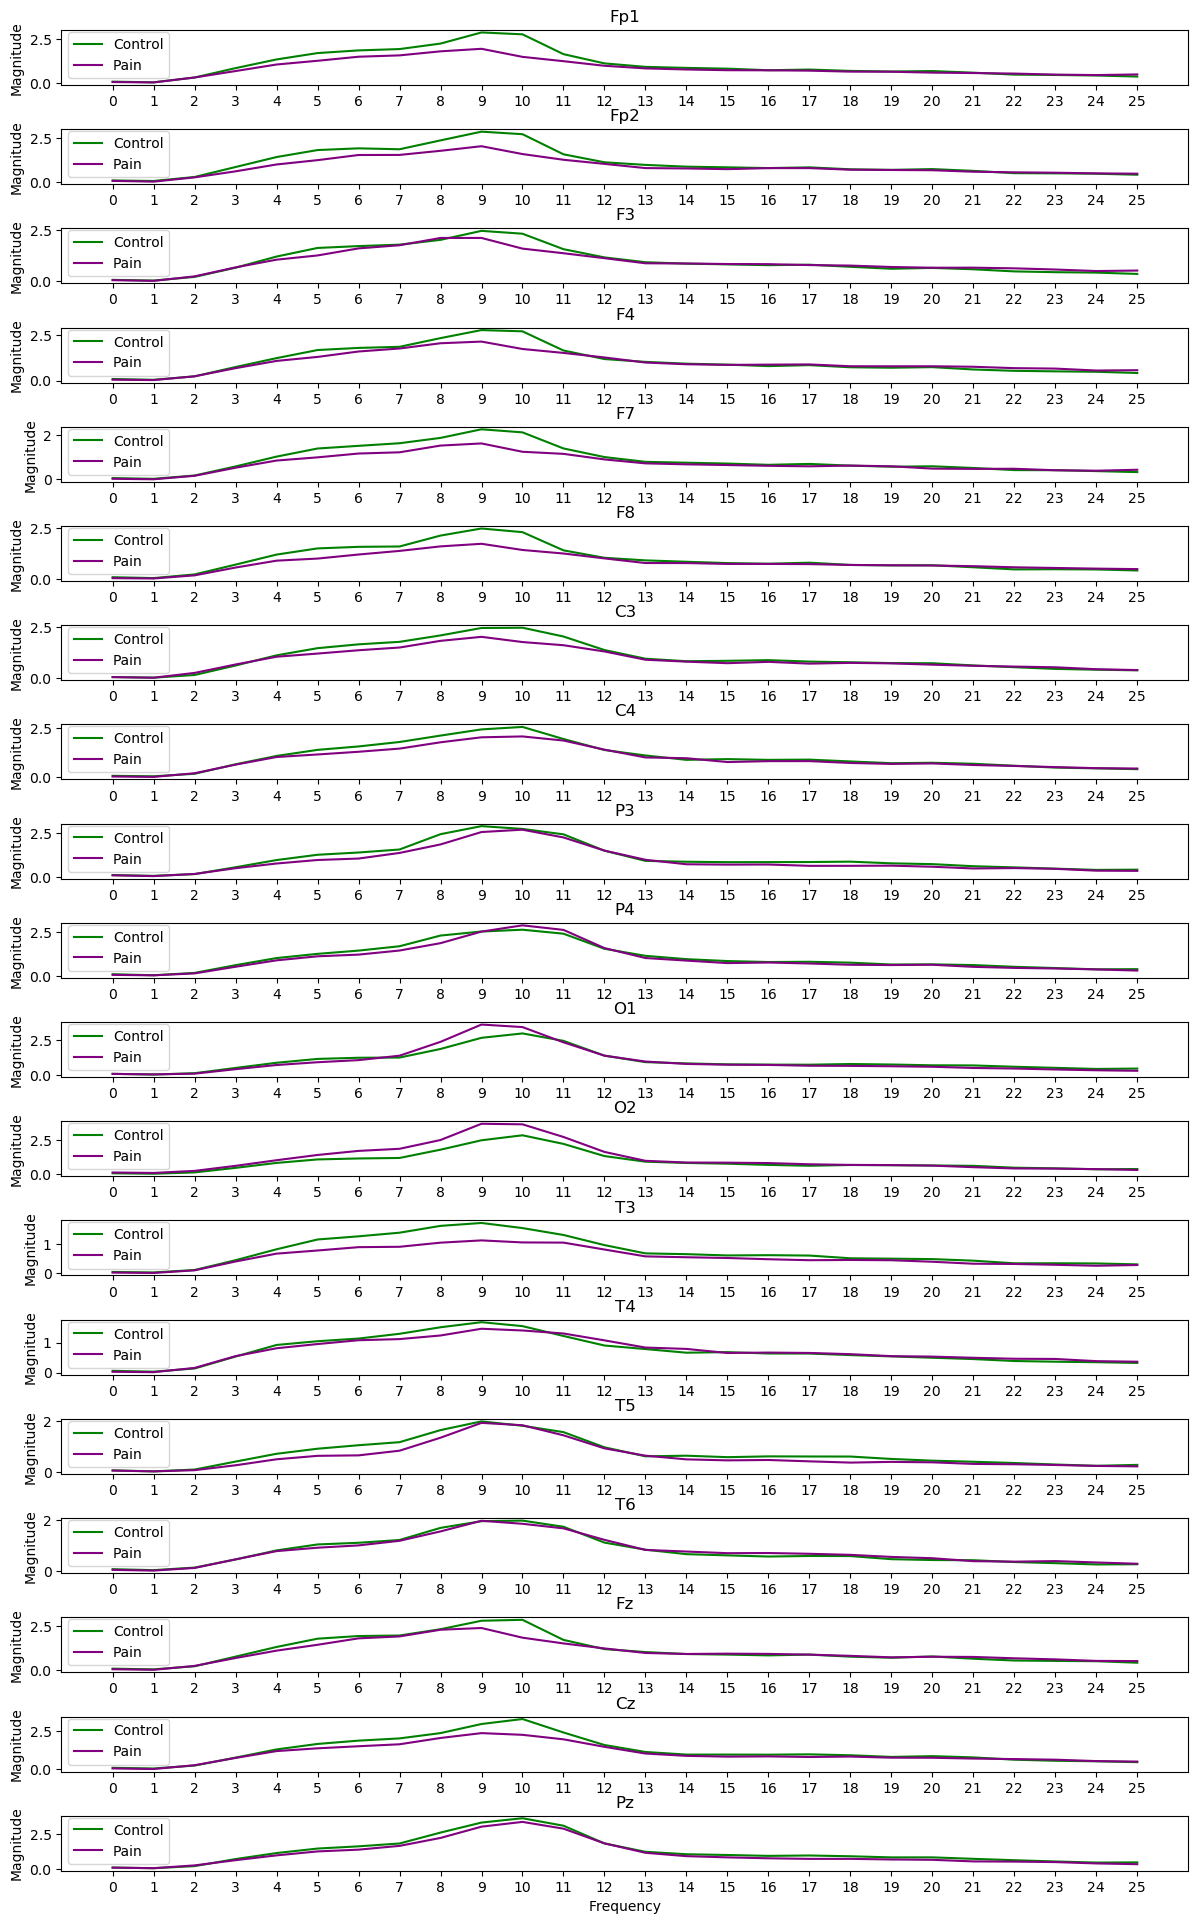

In [11]:
if args["data_type"] == "spectra":
    specavgObj = SpectralAverage(myclf)
    specavgObj.plot()

<h3> Train CNN </h4>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
conv2d (Conv2D)              multiple                  50        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  20        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  230       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  2

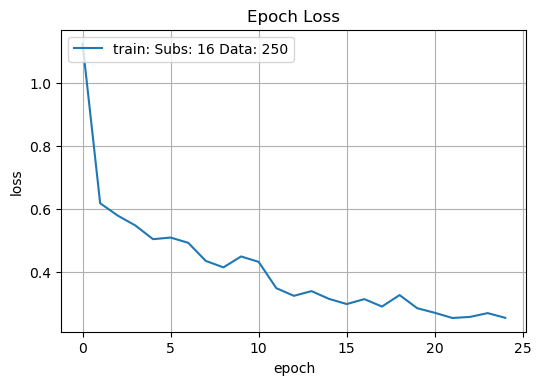

In [12]:
model, y_pred_keras, myclf.test_labels = myclf.CNN(
    normalize=args['normalize'],
    learning_rate=args['learning_rate'],
    lr_decay=args['lr_decay'],
    epochs=args['epochs'],
    plot_ROC=args['plot_ROC'])

<h3> Evaluate Saved Model </h3>
<p> Set the path of the checkpoint directory below </p>

In [13]:
args["checkpoint_dir"] = ""

<p> (or just use the most recent one) </p>

In [14]:
if args["checkpoint_dir"] == "":
    args["checkpoint_dir"] = os.listdir("logs/fit/")[-1]

<h4> Purge myclf.data and Load in Evaluation Data </h4>

In [15]:
myclf.data = []

# Load in evaluation data
eval_path = patient_path.replace(args['study_name'], args['eval_study'])

for fname in os.listdir(eval_path):
    if "_"+args['filter_band'] in fname:
        myclf.LoadData(
            eval_path
            +"/"
            +fname)

In [16]:
# pop off data from the class with less data until class sizes are equal
groups = []
for dataObj in myclf.data:
    if dataObj.group not in groups:
        groups.append(dataObj.group)
            
group_sizes = []
for group in groups:
    group_size = 0
    for dataObj in myclf.data:
        if dataObj.group == group:
            group_size+=1
    group_sizes.append(group_size)
    
random.shuffle(myclf.data)

if len(groups) > 2 or len(groups) < 1:
    raise ValueError
else:
    larger_group = group_sizes.index(np.max(group_sizes))
    smaller_group = group_sizes.index(np.min(group_sizes))
    
for i, group in enumerate(groups):
    print("Type:", config.group_names[group], "\tAmount:", group_sizes[i])

Type: Pain 	Amount: 773


<h4> Structure Data for TF </h4>

In [17]:
myclf.Prepare(tt_split=1)

Number of negative outcomes: 0
Number of positive outcomes: 773
Total number of subjects: 12
% Positive in all subjects: 1.0
% Negative in all subjects: 0.0
Number of samples in train: 773
Number of samples in test: 773
% Positive samples in train: 0.0
% Positive samples in test: 1.0


<h4> Show Spectral Averages of Evaluation Data, by Group </h4>

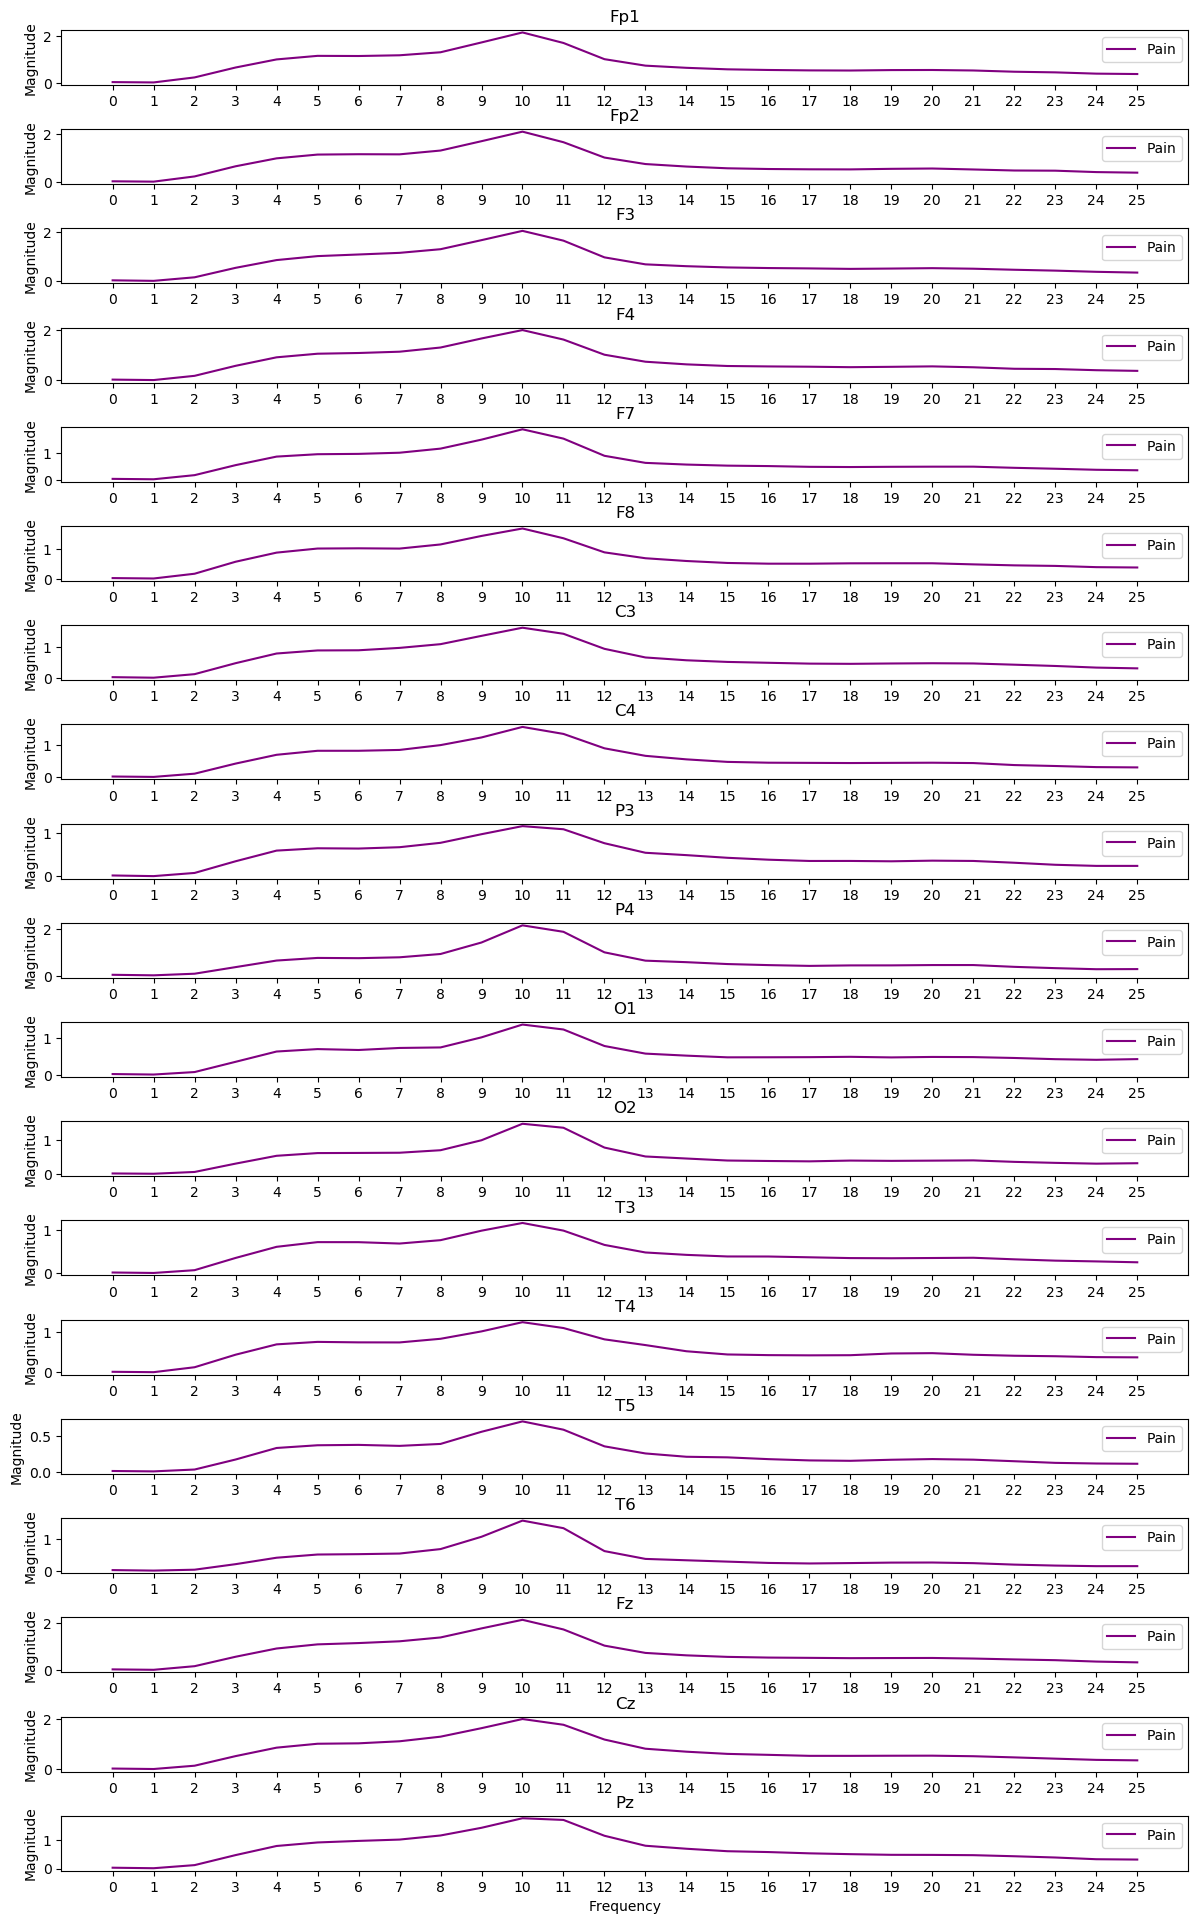

In [18]:
if args["data_type"] == "spectra":
    specavgObj = SpectralAverage(myclf)
    specavgObj.plot()

<h3> Evaluate Model </h3>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
conv2d (Conv2D)              multiple                  50        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  20        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  230       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  2

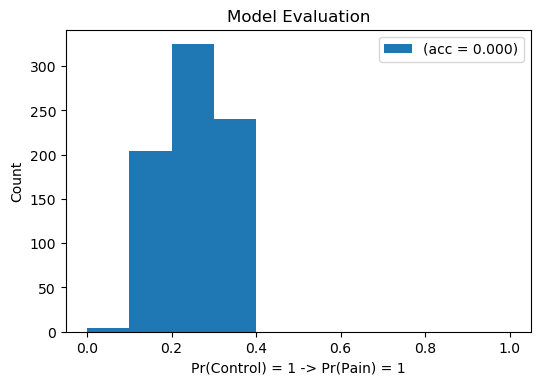

In [19]:
y_preds = myclf.eval_saved_CNN(
    "logs/fit/"+args["checkpoint_dir"],
    plot_hist=args['plot_hist'])

<h3> Reassign Groups Based on Model Output, and Show Spectral Averages </h3>

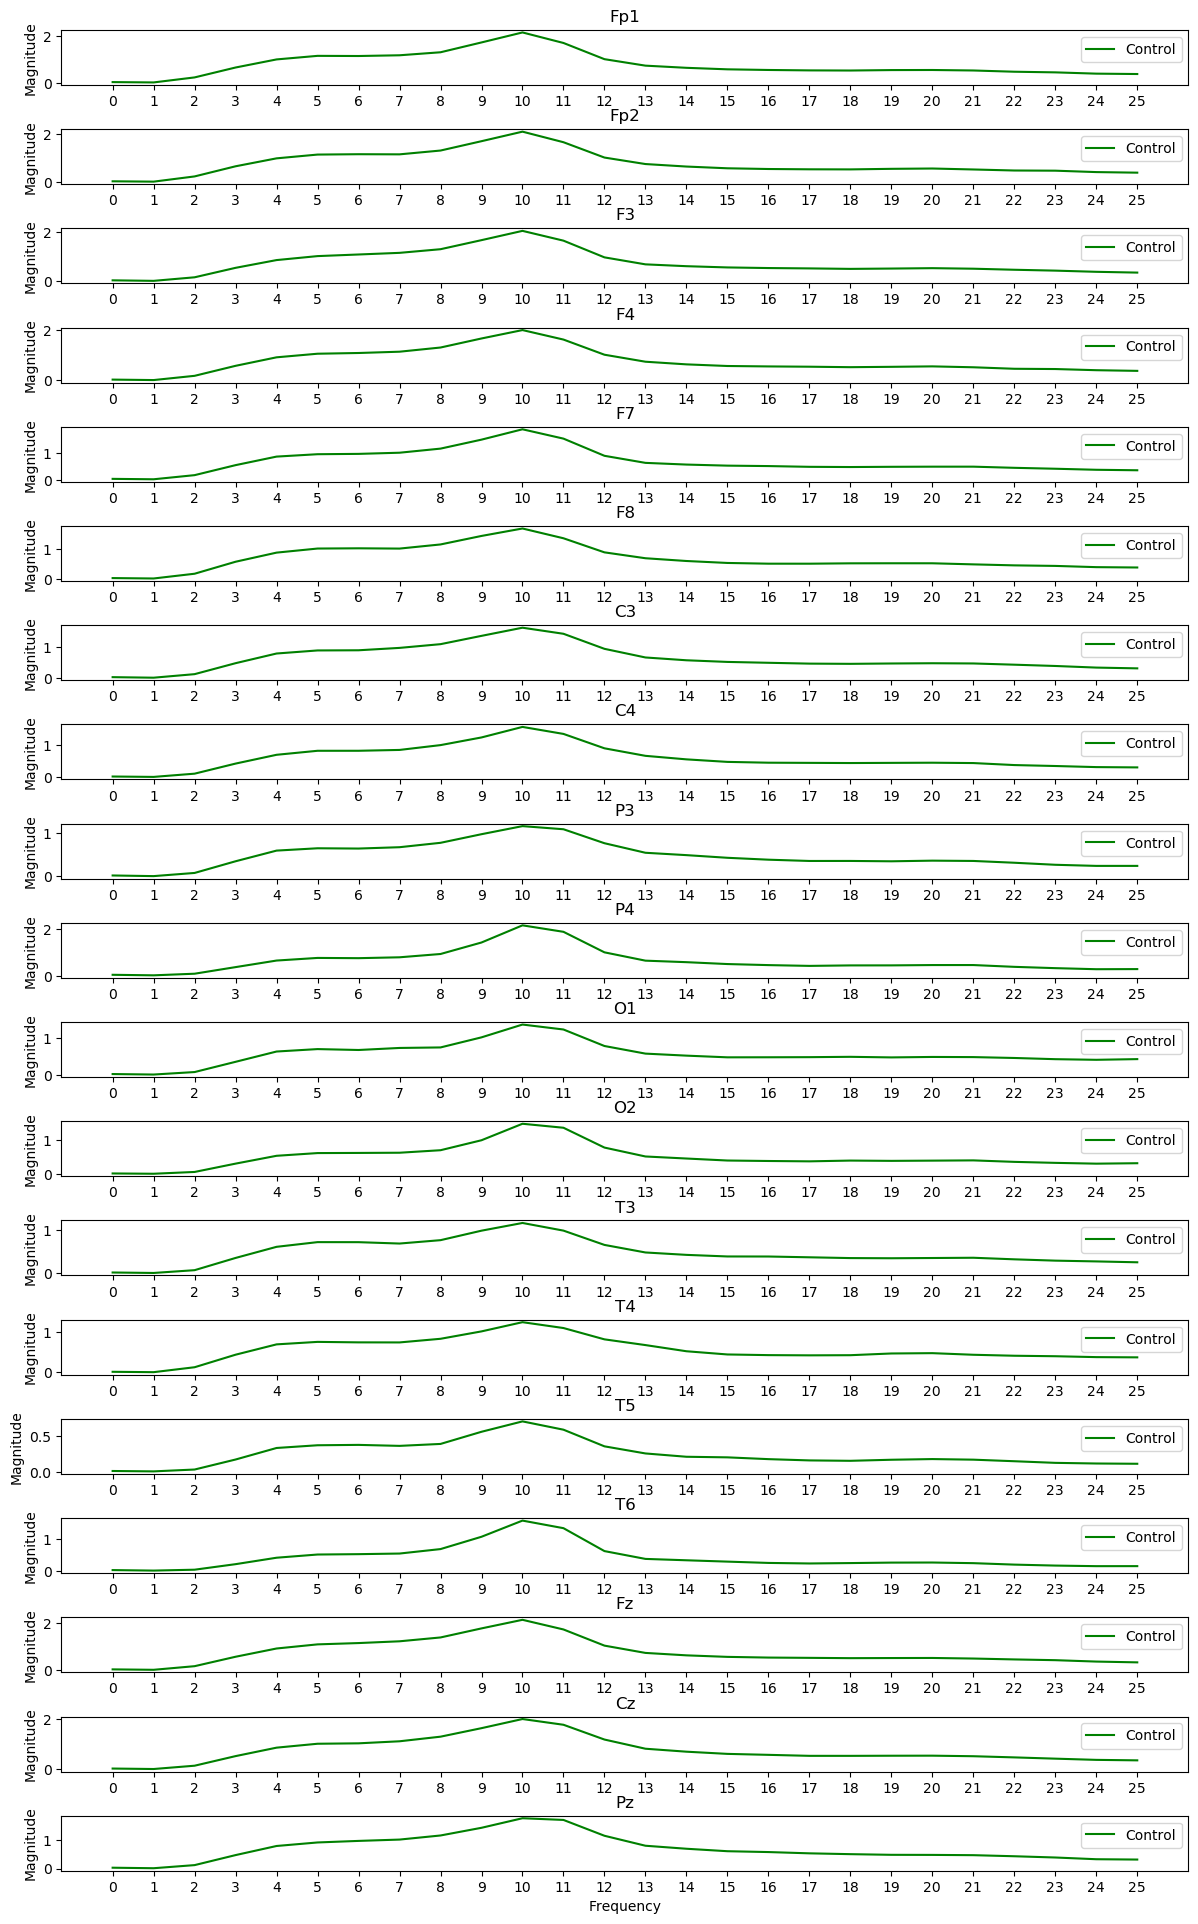

In [20]:
for i, (pred, inputObj) in enumerate(zip(np.rint(y_preds), myclf.data)):
    inputObj.group = myclf.groups[int(pred)]
    
if args["data_type"] == "spectra":
    specavgObj = SpectralAverage(myclf)
    specavgObj.plot()